# Measuring the Time Complexity of the Implementation

Since the algorithm iterates over the strings `2n` times, and each substring `log(n)` times, I think we can classify its time complexity as **linear**. But it's always good to verify empirically, if possible. 

Slice the original string file into sub-files, increasing each by 5k lines

In [ ]:
%bash
for (( START=5000; START<=500000; START+=5000 )); do
    sed -n 1,"$START"p words.txt > files/words_$START.txt
done

Time the calculation using `Hyperfine`. There are 10 warm-up runs, followed by 20 measured runs.

In [ ]:
%bash
for (( START=5000; START<=500000; START+=5000 )); do
    hyperfine --warmup 10 --min-runs 20 -s basic 'target/release/patterns files/words_'"$START"'.txt' >> stats.txt
done

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import summary_table

import re

In [74]:
%matplotlib inline

In [16]:
# extract timings and noise
reg = re.compile(r"\S*:\s*(\d*\.\d*)\sms\s±\s*(\d*\.\d*)\sms")

In [116]:
fields = ['time', 'error']

with open("stats.txt", "r") as f:
    matches = (reg.findall(line) for line in f)
    cleaned = (m for m in matches if len(m))
    df = pd.DataFrame([dict(zip(fields, *entry)) for entry in cleaned])

In [118]:
# convert strings to float
df.time = pd.to_numeric(df.time)
df.error = pd.to_numeric(df.error)
# add number of entries
df['entries'] = np.array([e for e in xrange(5000, 505000, 5000)])

In [ ]:
# I suspect that there is a linear relationship between number of strings and comparison time
fit = sm.ols(
     formula='time ~ entries',
     data=df).fit()
fit.summary()

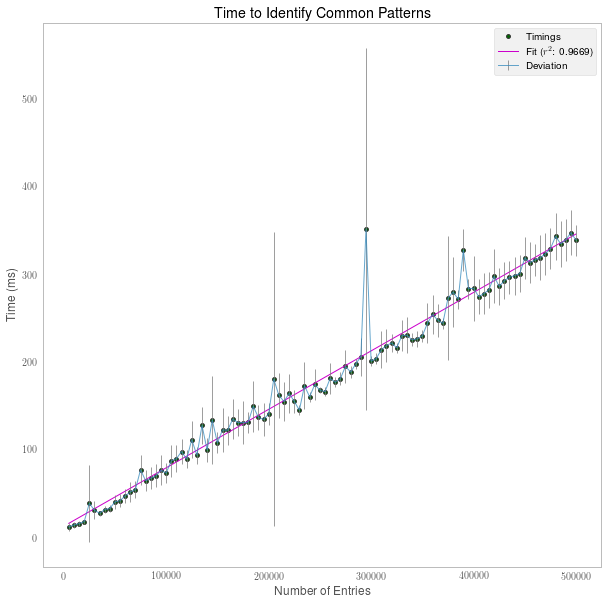

In [141]:
plt.clf()
fig = plt.figure(figsize=(10., 10.))
ax = fig.add_subplot(111, axisbg='none')
measured = plt.scatter(
    df['entries'], df['time'],
    s=15, marker='o', color='#006600', edgecolor='#333333', lw=1
)
err = plt.errorbar(
    df['entries'], df['time'], yerr=df['error'],
    ecolor='#7e7e7e', alpha=.75
)
# Line of best fit
fitted, = plt.plot(
    df['entries'],
    fit.predict(),
    color='#CC00CC',
    zorder=1)
leg = plt.legend(
    (measured, fitted, err),
    ("Timings", "Fit ($r^2$: %0.4f)" % fit.rsquared, "Deviation"))
ax.set_xlabel('Number of Entries')
ax.set_ylabel('Time (ms)')
plt.title("Time to Identify Common Patterns")
plt.show()

###  This implementation has O(n) time complexity